In [1]:
import numpy as np
import networkx as nx
from node2vec import Node2Vec
import random
from gensim.models import Word2Vec

from pyclustering.cluster import kmeans , clique

import os

from itertools import combinations 


import warnings
warnings.filterwarnings("ignore")

import sklearn
sklearn.__version__

'0.22.1'

In [2]:
def reading_graph(edgefile):
    #Reads the input network in networkx.
    G = nx.read_edgelist(edgefile, nodetype=int, create_using=nx.Graph())
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1
        
    return G

In [3]:
########## read the graph ##########

G22=reading_graph('edge_file_new_0.05.txt')

node_id1=list(G22.nodes())

test_list = list(map(int, node_id1)) 

test_list.sort()

#print(test_list)

node_id=test_list
print(node_id)
print(len(node_id))

print(len(G22.edges()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
100
422


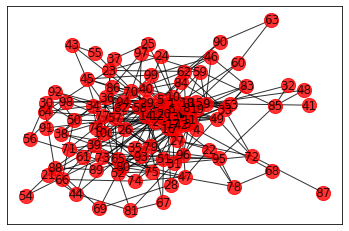

In [4]:
pos=nx.spring_layout(G22) # positions for all nodes
nx.draw_networkx(G22,pos,nodelist=node_id1, node_color='r', node_size=200, alpha=0.8)

In [196]:
def alias_setup(probs):
	'''
	Compute utility lists for non-uniform sampling from discrete distributions.
	Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
	for details
	'''
	K = len(probs)
	q = np.zeros(K)
	J = np.zeros(K, dtype=np.int)

	smaller = []
	larger = []
	for kk, prob in enumerate(probs):
	    q[kk] = K*prob
	    if q[kk] < 1.0:
	        smaller.append(kk)
	    else:
	        larger.append(kk)

	while len(smaller) > 0 and len(larger) > 0:
	    small = smaller.pop()
	    large = larger.pop()

	    J[small] = large
	    q[large] = q[large] + q[small] - 1.0
	    if q[large] < 1.0:
	        smaller.append(large)
	    else:
	        larger.append(large)

	return J, q

In [86]:
def alias_draw(J, q):
	'''
	Draw sample from a non-uniform discrete distribution using alias sampling.
	'''
	K = len(J)

	kk = int(np.floor(np.random.rand()*K))
	if np.random.rand() < q[kk]:
	    return kk
	else:
	    return J[kk]

In [5]:
    
import random

def uniform_draw(pr, Id):
    
### Draw uniform sampling based on probality distribution 

    pr_array=pr
    id_array=Id
        
    cum_pr_array=[]
    
    cumsum = 0
    for element in pr_array:
        cumsum += element
        cum_pr_array.append(cumsum)
 
    #print(cum_pr_array)
    #seed(1)
    x = random.random()
    length=len(cum_pr_array)
    
    for i in range(length):
        if x <  cum_pr_array[i]:
            return_node=id_array[i]
            break
            
    return return_node
        

In [138]:

class Graph():
	def __init__(self, nx_G, p, q, k):
		self.G = nx_G
		self.p = p
		self.q = q
		self.k = k
        
	def get_alias_edge(self, src, dst):
		'''
		Get the alias edge setup lists for a given edge.
		'''
		G = self.G
		p = self.p
		q = self.q
		k = self.k 

		unnormalized_probs = []
		sorted_node_id = []
        
		for dst_nbr in sorted(G.neighbors(dst)):
			if G.degree(dst_nbr) > k:
				if G.has_edge(dst_nbr, src):
					unnormalized_probs.append(G[dst][dst_nbr]['weight']*p)
					sorted_node_id.append(dst_nbr)
				else:
					unnormalized_probs.append(G[dst][dst_nbr]['weight']*q)
					sorted_node_id.append(dst_nbr)
			else:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']*(1-p-q))
				sorted_node_id.append(dst_nbr)


                
		norm_const = sum(unnormalized_probs)
		normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

		return normalized_probs, sorted_node_id


	def preprocess_transition_probs(self):
		'''
		Preprocessing of transition probabilities for guiding the random walks.
		'''
		G = self.G

		alias_nodes = {}
		for node in G.nodes():
			unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
			norm_const = sum(unnormalized_probs)
			normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
			sorted_node_id1=[nbr for nbr in sorted(G.neighbors(node))]            
			alias_nodes[node] = normalized_probs, sorted_node_id1



		alias_edges = {}
		triads = {}

		for edge in G.edges():
			alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
			alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])
            
		self.alias_nodes = alias_nodes
		self.alias_edges = alias_edges

		return
    
  
	def node2vec_walk(self, walk_length, start_node):
		'''
		Simulate a random walk starting from start node.
		'''
		G = self.G
		alias_nodes = self.alias_nodes
		alias_edges = self.alias_edges

		walk = [start_node]

		while len(walk) < walk_length:
			cur = walk[-1]
			cur_nbrs = sorted(G.neighbors(cur))
			if len(cur_nbrs) > 0:
				if len(walk) == 1:
					walk.append(uniform_draw(alias_nodes[cur][0], alias_nodes[cur][1]))
				else:
					prev = walk[-2]
					next = uniform_draw(alias_edges[(prev, cur)][0], alias_edges[(prev, cur)][1])
					walk.append(next)
			else:
				break

		return walk
    
	def simulate_walks(self, num_walks, walk_length):
		'''
		Repeatedly simulate random walks from each node.
		'''
		G = self.G
		walks = []
		nodes = list(G.nodes())
		print ('Walk iteration:')
		for walk_iter in range(num_walks):
			print (str(walk_iter+1), '/', str(num_walks))
			random.shuffle(nodes)
			for node in nodes:
				walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

		return walks


In [151]:
#######  initialize the grapg G22 with input parameters p (0.85), q (0.15), k(degree threshold: 10) : (p+q=1)

g22=Graph(G22, 0.8, 0.2, 1)

In [152]:
g22.preprocess_transition_probs()

In [153]:
###########  input parameters : number of walk _per source (here 10) and walk length (here 30)

import random
random_walk=g22.simulate_walks(10,30)
print(len(random_walk))
print(random_walk)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
1000
[[66, 61, 89, 93, 12, 3, 1, 13, 18, 1, 19, 14, 16, 15, 7, 4, 10, 20, 73, 2, 11, 5, 17, 12, 15, 19, 83, 15, 60, 15], [74, 17, 13, 4, 20, 8, 58, 11, 10, 13, 12, 18, 15, 16, 4, 10, 2, 4, 5, 8, 2, 4, 11, 5, 1, 2, 1, 3, 7, 11], [5, 18, 11, 12, 5, 7, 20, 18, 8, 6, 12, 4, 10, 3, 8, 10, 4, 6, 12, 2, 13, 20, 3, 5, 19, 12, 14, 5, 8, 9], [73, 52, 27, 99, 46, 99, 46, 24, 23, 59, 97, 58, 51, 67, 79, 77, 76, 82, 99, 27, 22, 47, 74, 73, 96, 11, 3, 12, 3, 93], [67, 79, 42, 2, 20, 4, 12, 1, 3, 15, 5, 11, 20, 19, 14, 18, 19, 8, 11, 3, 6, 19, 4, 13, 1, 3, 5, 15, 18, 7], [10, 16, 9, 6, 11, 1, 5, 19, 8, 13, 7, 20, 13, 12, 13, 18, 4, 9, 48, 85, 32, 19, 32, 19, 5, 4, 5, 90, 63, 60], [22, 78, 68, 78, 68, 4, 58, 11, 3, 9, 12, 14, 3, 18, 2, 20, 73, 2, 20, 61, 66, 44, 65, 47, 22, 27, 94, 14, 11, 12], [94, 27, 22, 27, 52, 73, 96, 73, 2, 13, 16, 53, 8, 19, 16, 6, 5, 30, 56, 98, 56, 98, 1, 2, 7, 18, 10, 17, 9, 3], [27, 22, 2

In [154]:

def aggregatedwalkcreate(random_walk_list,keep_no_of_elements):
    
    random_walk_data=np.array(random_walk_list)
    print(len(random_walk_data[1]))

    aggregated_random_walk=[]

    for i in range(len(node_id)):

        individual_id_agrt_array=[node_id[i]]

        print(node_id[i])
        
        locations=np.where(random_walk_data[:,0:1]==node_id[i])
        x_axis_location=locations[0]
        #print(x_axis_location)

        appended_total_walk_array=[]

        for i1 in x_axis_location:
                appended_total_walk_array.extend(random_walk_data[i1,1:len(random_walk_data[1])])

        ######## calulate element occurring with frequency in aggregated walk #####################

        unique_elements, counts_elements = np.unique(appended_total_walk_array, return_counts=True)

        arr2D=np.asarray((unique_elements, counts_elements))
        #print(np.asarray((unique_elements, counts_elements)))
        sortedArr = arr2D [ :, arr2D[1].argsort()]
        #print(sortedArr)
        reverse_sortedArr = sortedArr[...,::-1]
        #print(reverse_sortedArr)

        ######### keep no. of most frequent elements in random walk ###########

        no_keep_most_frequent_elements=keep_no_of_elements
        most_frequent_elements=reverse_sortedArr[0][0:no_keep_most_frequent_elements]
        print((most_frequent_elements))

        individual_id_agrt_array.extend(list(most_frequent_elements))
        print(individual_id_agrt_array)

        aggregated_random_walk.append(individual_id_agrt_array)
    
    return aggregated_random_walk   
    
#print(final_aggregated_random_walk)

In [155]:
final_aggregated_random_walk=aggregatedwalkcreate(random_walk, 20)
print(final_aggregated_random_walk)

30
1
[ 4 13 16  3 17  8  6 18 19 20  2  9 14  7  1 10  5 15 12 11]
[1, 4, 13, 16, 3, 17, 8, 6, 18, 19, 20, 2, 9, 14, 7, 1, 10, 5, 15, 12, 11]
2
[12  1  4 10 13  8 14  7 11 16 20  2  5 18  3  9 15 17  6 19]
[2, 12, 1, 4, 10, 13, 8, 14, 7, 11, 16, 20, 2, 5, 18, 3, 9, 15, 17, 6, 19]
3
[11  7  9  1 10 19 14  8  2 12  6  3 13 20 18  5 16  4 15 17]
[3, 11, 7, 9, 1, 10, 19, 14, 8, 2, 12, 6, 3, 13, 20, 18, 5, 16, 4, 15, 17]
4
[20 11  1  3  2  9  4 14 17  5 19 15 10 12 16  7 13  6  8 18]
[4, 20, 11, 1, 3, 2, 9, 4, 14, 17, 5, 19, 15, 10, 12, 16, 7, 13, 6, 8, 18]
5
[12  2 20  4  5 10  9 11  7  3  8  6 19 18 16 14 17  1 13 15]
[5, 12, 2, 20, 4, 5, 10, 9, 11, 7, 3, 8, 6, 19, 18, 16, 14, 17, 1, 13, 15]
6
[ 7 20  2 16 10  5  8 14 13  9  1  4 11 12  6 17 18  3 15 19]
[6, 7, 20, 2, 16, 10, 5, 8, 14, 13, 9, 1, 4, 11, 12, 6, 17, 18, 3, 15, 19]
7
[ 8 17 13 18  2 14  9 12  4 10  5 19 20  3 11 15 16  1  6 50]
[7, 8, 17, 13, 18, 2, 14, 9, 12, 4, 10, 5, 19, 20, 3, 11, 15, 16, 1, 6, 50]
8
[ 4  3 19 12 17 16  1

In [127]:
def learn_embeddings(walks):
    #Learn embeddings by optimizing the Skipgram objective using SGD.
    walks = [list(map(str, walk)) for walk in walks]
    #print(walks)
    model = Word2Vec(walks, size=128, window=20, min_count=0, sg=1, workers=8, iter=1)
    #print(model)
    model.wv.save_word2vec_format('output')
    return

In [128]:
learn_embeddings(random_walk)

In [129]:
learn_embeddings(final_aggregated_random_walk)

In [149]:
### save random walk file ###########

os.remove('random_walk_file')

with open("random_walk_file", "w") as rwkfileid:

    #print(len(random_walk))
    
    for i3 in range(len(random_walk)):
        
        random_walk_set=random_walk[i3]
        
        #print(len(random_walk_set))
        
        for i4 in range(len(random_walk_set)):
            
            rwkfileid.write("%s " % int(random_walk_set[i4]))
            
        rwkfileid.write("\n")    
        

In [150]:
### save random walk file ###########

os.remove('aggregated_random_walk_file')

with open("aggregated_random_walk_file", "w") as agrtrwkfileid:

    #print(len(random_walk))
    
    for i5 in range(len(final_aggregated_random_walk)):
        
        final_aggregated_random_walk_set=final_aggregated_random_walk[i5]
        
        #print(len(random_walk_set))
        
        for i6 in range(len(final_aggregated_random_walk_set)):
            
            agrtrwkfileid.write("%s " % int(final_aggregated_random_walk_set[i6]))
            
        agrtrwkfileid.write("\n")    
        

In [25]:
#####################################################################################################